In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Enable inline plotting
%matplotlib inline

# Set style for all plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
base_folder = 'C:\\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Data_Mor'

def load_city_data(base_folder, city, date):
    """Load and preprocess data for a specific city and date."""
    base_path = os.path.join(base_folder, city, date)
    
    # Load data files
    listings = pd.read_csv(f"{base_path}/listings.csv", low_memory=False)
    calendar = pd.read_csv(f"{base_path}/calendar.csv", low_memory=False)
    neighborhoods = pd.read_csv(f"{base_path}/neighbourhoods.csv")
    
    # Clean price columns
    listings['price_clean'] = listings['price'].str.replace('$','').str.replace(',','').astype(float)
    calendar['price_clean'] = calendar['price'].str.replace('$','').str.replace(',','').astype(float)
    calendar['date'] = pd.to_datetime(calendar['date'])
    
    return listings, calendar, neighborhoods

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matth\AppData\Local\Temp\ipykernel_21336\3300206738.py:14: SyntaxWarning: invalid escape sequence '\m'
  base_folder = 'C:\\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Data_Mor'


**EDA**

In [2]:
def print_basic_stats(listings, city, date):
    """Print basic statistics about the dataset."""
    print(f"\nBasic Statistics for {city.capitalize()} ({date}):")
    print("-" * 50)
    print(f"Number of listings: {len(listings):,}")
    print(f"Average price: ${listings['price_clean'].mean():.2f}")
    print(f"Median price: ${listings['price_clean'].median():.2f}")
    print(f"Number of neighborhoods: {listings['neighbourhood_cleansed'].nunique()}")
    print("-" * 50)

In [3]:
def plot_price_distributions(listings, city, date):
    """Plot price distribution visualizations."""
    plt.figure(figsize=(15, 5))
    price_data = listings['price_clean'][listings['price_clean'] <= listings['price_clean'].quantile(0.99)]
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=price_data, bins=50)
    plt.title('Price Distribution\n(≤99th percentile)')
    plt.xlabel('Price ($)')
    
    plt.subplot(1, 2, 2)
    sns.histplot(data=price_data, bins=50)
    plt.yscale('log')
    plt.title('Price Distribution (Log Scale)\n(≤99th percentile)')
    plt.xlabel('Price ($)')
    plt.suptitle(f'Price Distributions in {city.capitalize()} ({date})', y=1.05)
    plt.tight_layout()
    plt.show()

In [5]:
def plot_neighborhood_analysis(listings):
    """Plot neighborhood analysis visualizations."""
    plt.figure(figsize=(20, 15))
    neighborhood_stats = listings.groupby('neighbourhood_cleansed').agg({
        'id': 'count',
        'price_clean': 'mean',
        'review_scores_rating': 'mean'
    }).round(2).sort_values('id', ascending=True)
    
    plt.subplot(2, 2, 1)
    neighborhood_stats['id'].plot(kind='barh')
    plt.title('Number of Listings by Neighborhood')
    plt.xlabel('Number of Listings')
    
    plt.subplot(2, 2, 2)
    neighborhood_stats['price_clean'].plot(kind='barh')
    plt.title('Average Price by Neighborhood')
    plt.xlabel('Price ($)')
    
    plt.subplot(2, 2, 3)
    neighborhood_stats['review_scores_rating'].plot(kind='barh')
    plt.title('Average Rating by Neighborhood')
    plt.xlabel('Rating')
    
    plt.subplot(2, 2, 4)
    plt.scatter(neighborhood_stats['review_scores_rating'], 
               neighborhood_stats['price_clean'],
               alpha=0.6)
    plt.xlabel('Rating')
    plt.ylabel('Price ($)')
    plt.title('Price vs Rating by Neighborhood')
    plt.tight_layout()
    plt.show()

In [6]:
def plot_seasonal_patterns(calendar):
    """Plot seasonal pattern visualizations."""
    plt.figure(figsize=(20, 15))
    
    # Daily average prices
    plt.subplot(2, 2, 1)
    daily_avg = calendar.groupby('date')['price_clean'].mean()
    daily_avg.plot()
    plt.title('Daily Average Prices')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    
    # Monthly average prices
    plt.subplot(2, 2, 2)
    monthly_avg = calendar.groupby(calendar['date'].dt.month)['price_clean'].mean()
    monthly_avg.plot(kind='bar')
    plt.title('Monthly Average Prices')
    plt.xlabel('Month')
    plt.ylabel('Price ($)')
    
    # Day of week average prices
    plt.subplot(2, 2, 3)
    dow_avg = calendar.groupby(calendar['date'].dt.day_name())['price_clean'].mean()
    dow_avg.plot(kind='bar')
    plt.title('Average Prices by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    
    # Availability by month
    plt.subplot(2, 2, 4)
    calendar['available'] = calendar['available'].map({'t': 1, 'f': 0})
    monthly_availability = calendar.groupby(calendar['date'].dt.month)['available'].mean() * 100
    monthly_availability.plot(kind='bar')
    plt.title('Monthly Availability')
    plt.xlabel('Month')
    plt.ylabel('Availability (%)')
    plt.tight_layout()
    plt.show()

In [7]:
def plot_room_type_analysis(listings):
    """Plot room type analysis visualizations."""
    plt.figure(figsize=(20, 15))
    
    plt.subplot(2, 2, 1)
    listings['room_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Room Type Distribution')
    
    plt.subplot(2, 2, 2)
    sns.barplot(data=listings, x='room_type', y='price_clean')
    plt.title('Average Price by Room Type')
    plt.xlabel('Room Type')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 3)
    sns.barplot(data=listings, x='room_type', y='review_scores_rating')
    plt.title('Average Rating by Room Type')
    plt.xlabel('Room Type')
    plt.ylabel('Rating')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 4)
    sns.boxplot(data=listings, x='room_type', y='price_clean')
    plt.title('Price Distribution by Room Type')
    plt.xlabel('Room Type')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [8]:
def analyze_reviews_ratings(listings):
    """Plot review scores analysis."""
    plt.figure(figsize=(12, 8))
    review_cols = [col for col in listings.columns if col.startswith('review_scores_')]
    review_corr = listings[review_cols].corr()
    sns.heatmap(review_corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between Review Scores')
    plt.tight_layout()
    plt.show()

In [9]:
def create_amenities_analysis(listings):
    """Plot amenities analysis if data is available."""
    if 'amenities' in listings.columns:
        # Process amenities
        try:
            listings['amenities_list'] = listings['amenities'].str.replace('"', '').str.replace("'", '"')
            listings['amenities_list'] = listings['amenities_list'].apply(eval)
        except:
            listings['amenities_list'] = listings['amenities'].str.strip('[]').str.split(',')
        
        listings['amenities_list'] = listings['amenities_list'].apply(
            lambda x: [item.strip().strip('"').strip("'") for item in x if item.strip()]
        )
        
        # Get top amenities
        all_amenities = []
        for amenity_list in listings['amenities_list']:
            all_amenities.extend(amenity_list)
        
        top_amenities = pd.Series(all_amenities).value_counts().head(20)
        
        plt.figure(figsize=(15, 12))
        
        plt.subplot(2, 1, 1)
        sns.barplot(x=top_amenities.values, y=top_amenities.index)
        plt.title('Top 20 Most Common Amenities')
        plt.xlabel('Number of Listings')
        
        # Calculate price impact
        price_impact = []
        amenity_names = []
        
        for amenity in top_amenities.index:
            has_amenity = listings['amenities_list'].apply(lambda x: amenity in x)
            if has_amenity.any() and (~has_amenity).any():
                avg_with = listings[has_amenity]['price_clean'].mean()
                avg_without = listings[~has_amenity]['price_clean'].mean()
                price_impact.append(avg_with - avg_without)
                amenity_names.append(amenity)
        
        plt.subplot(2, 1, 2)
        sns.barplot(x=price_impact, y=amenity_names)
        plt.title('Price Premium for Each Amenity')
        plt.xlabel('Price Difference ($)')
        plt.tight_layout()
        plt.show()



Basic Statistics for Paris (2023-09-04):
--------------------------------------------------
Number of listings: 67,942
Average price: $205.11
Median price: $125.00
Number of neighborhoods: 20
--------------------------------------------------


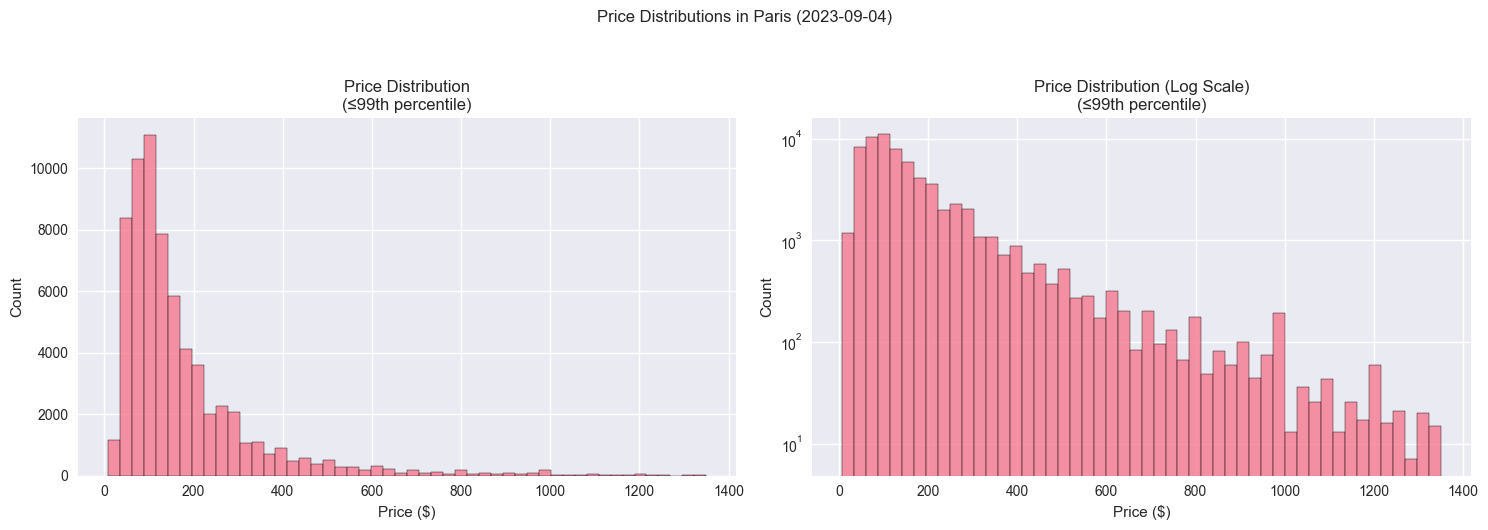

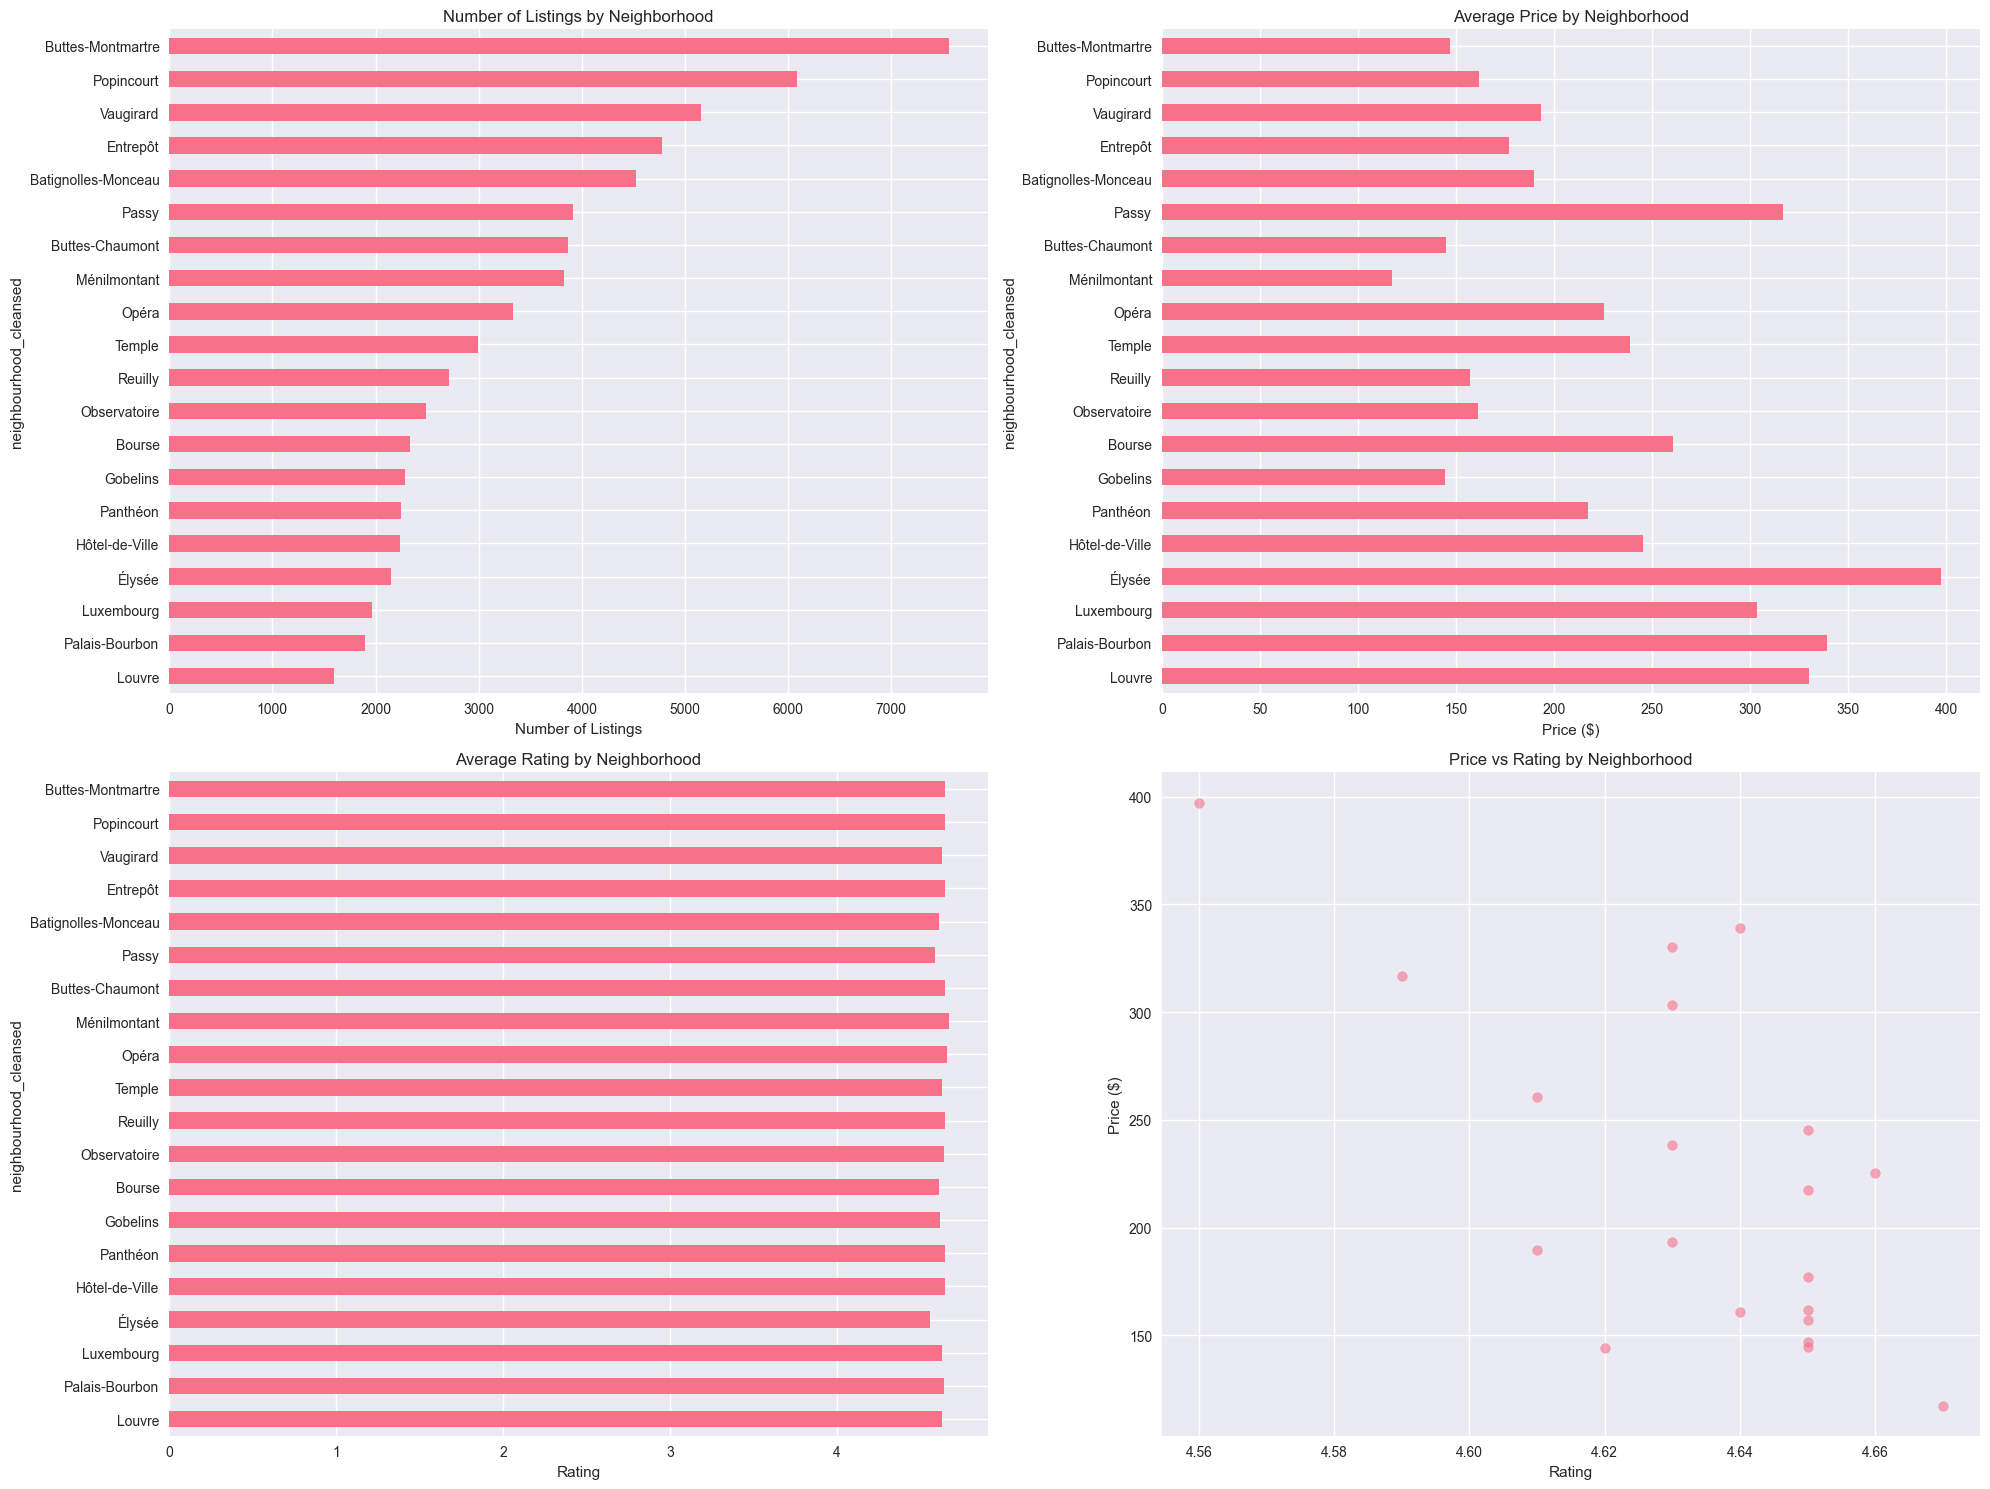

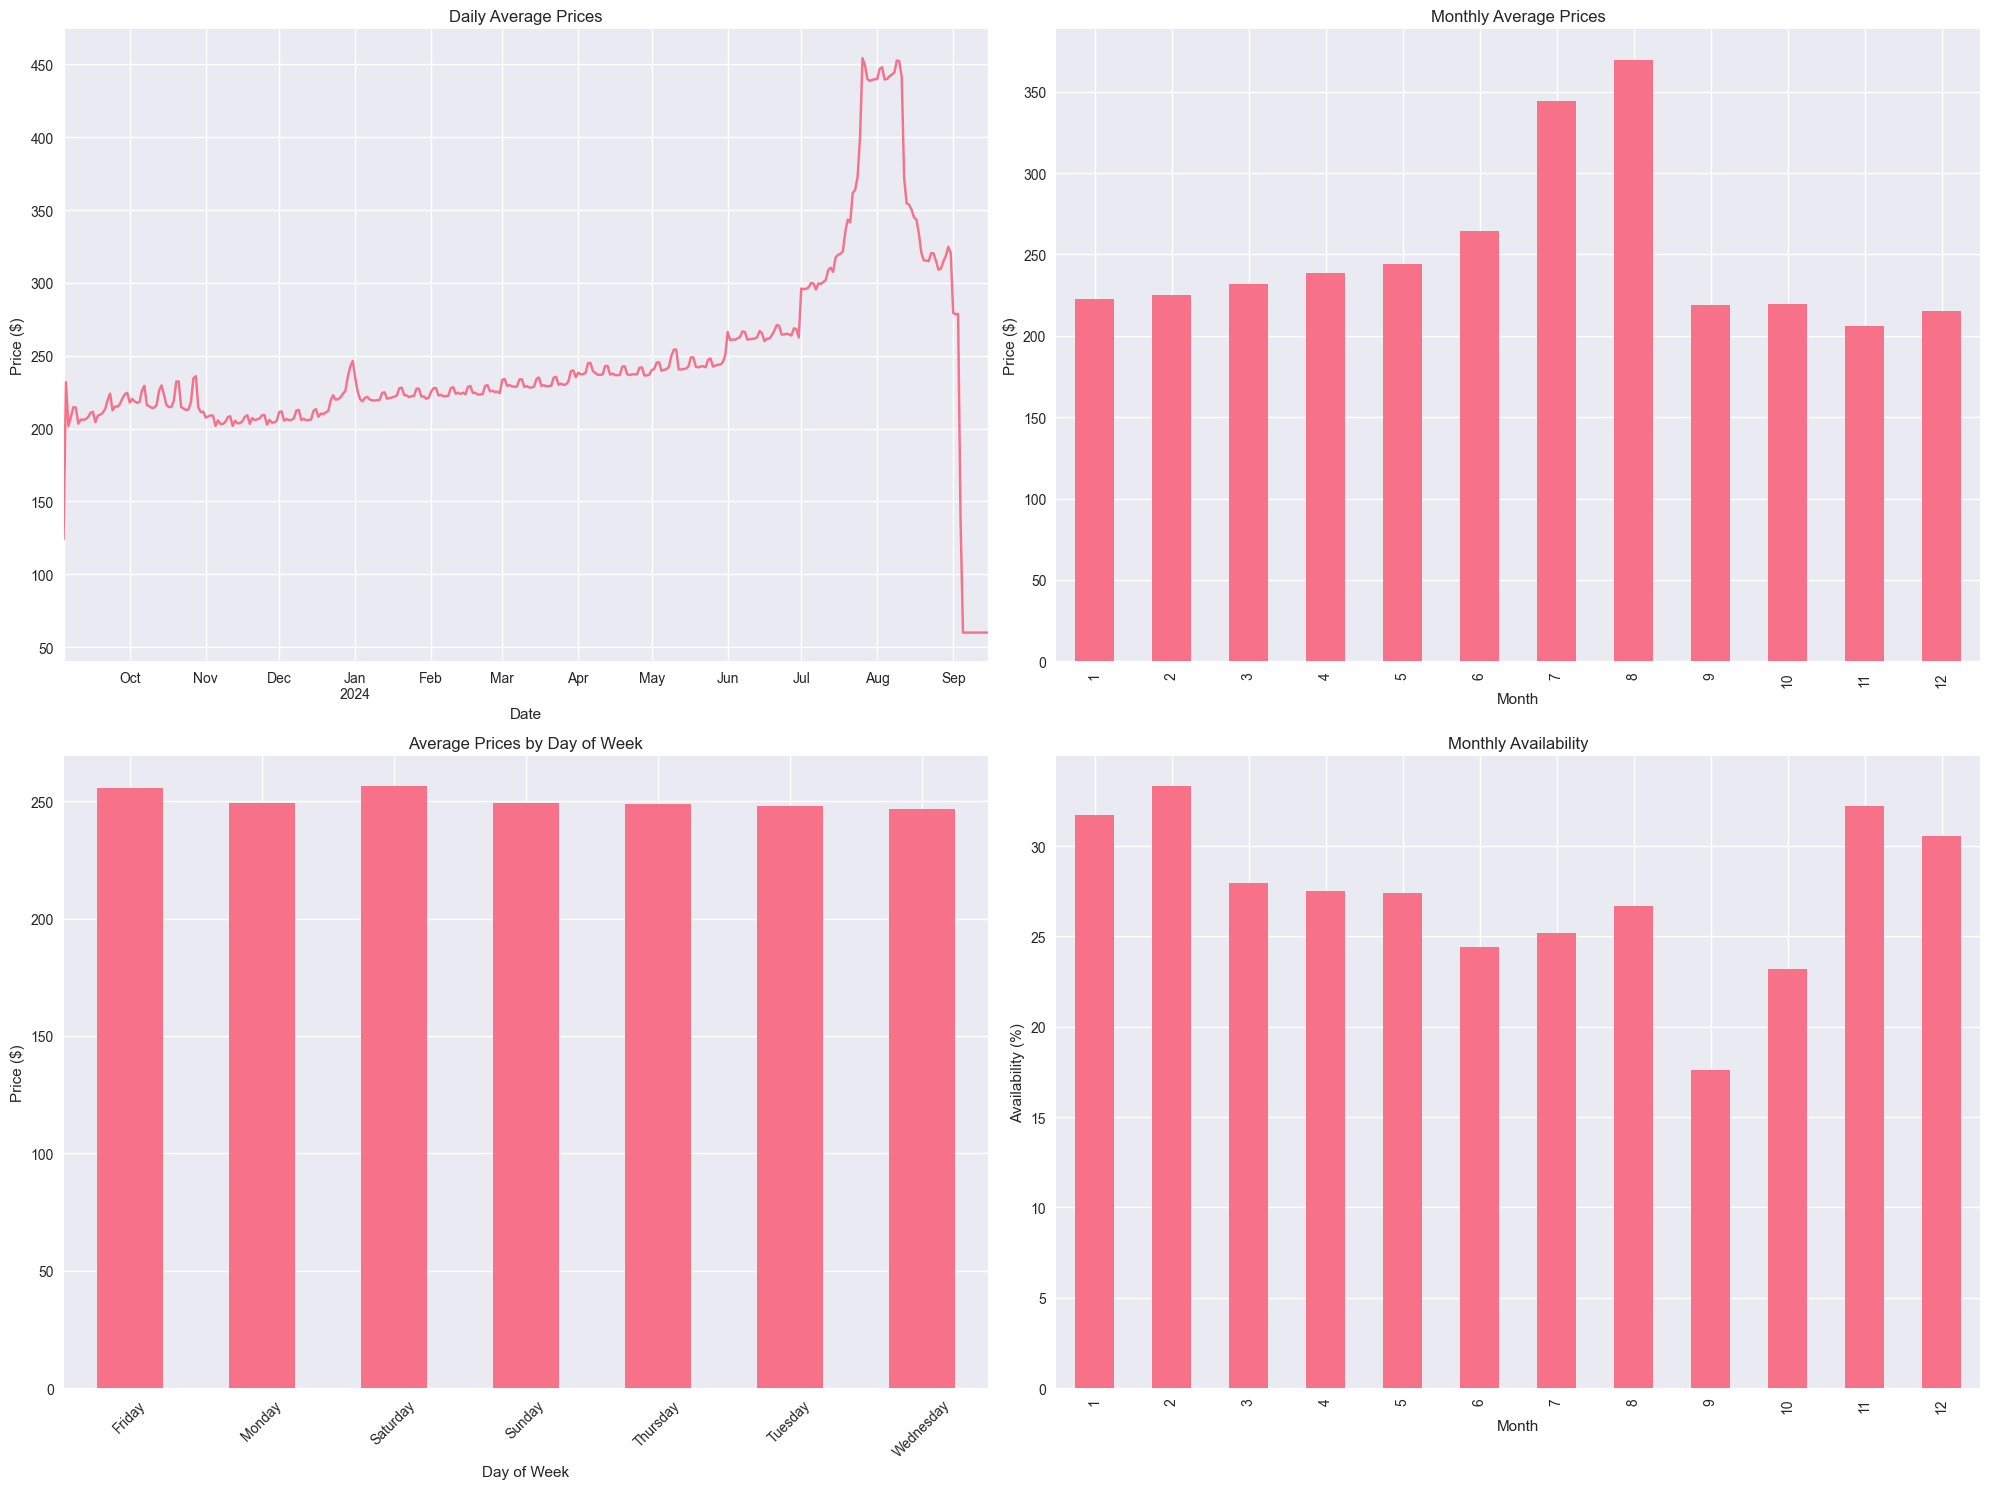

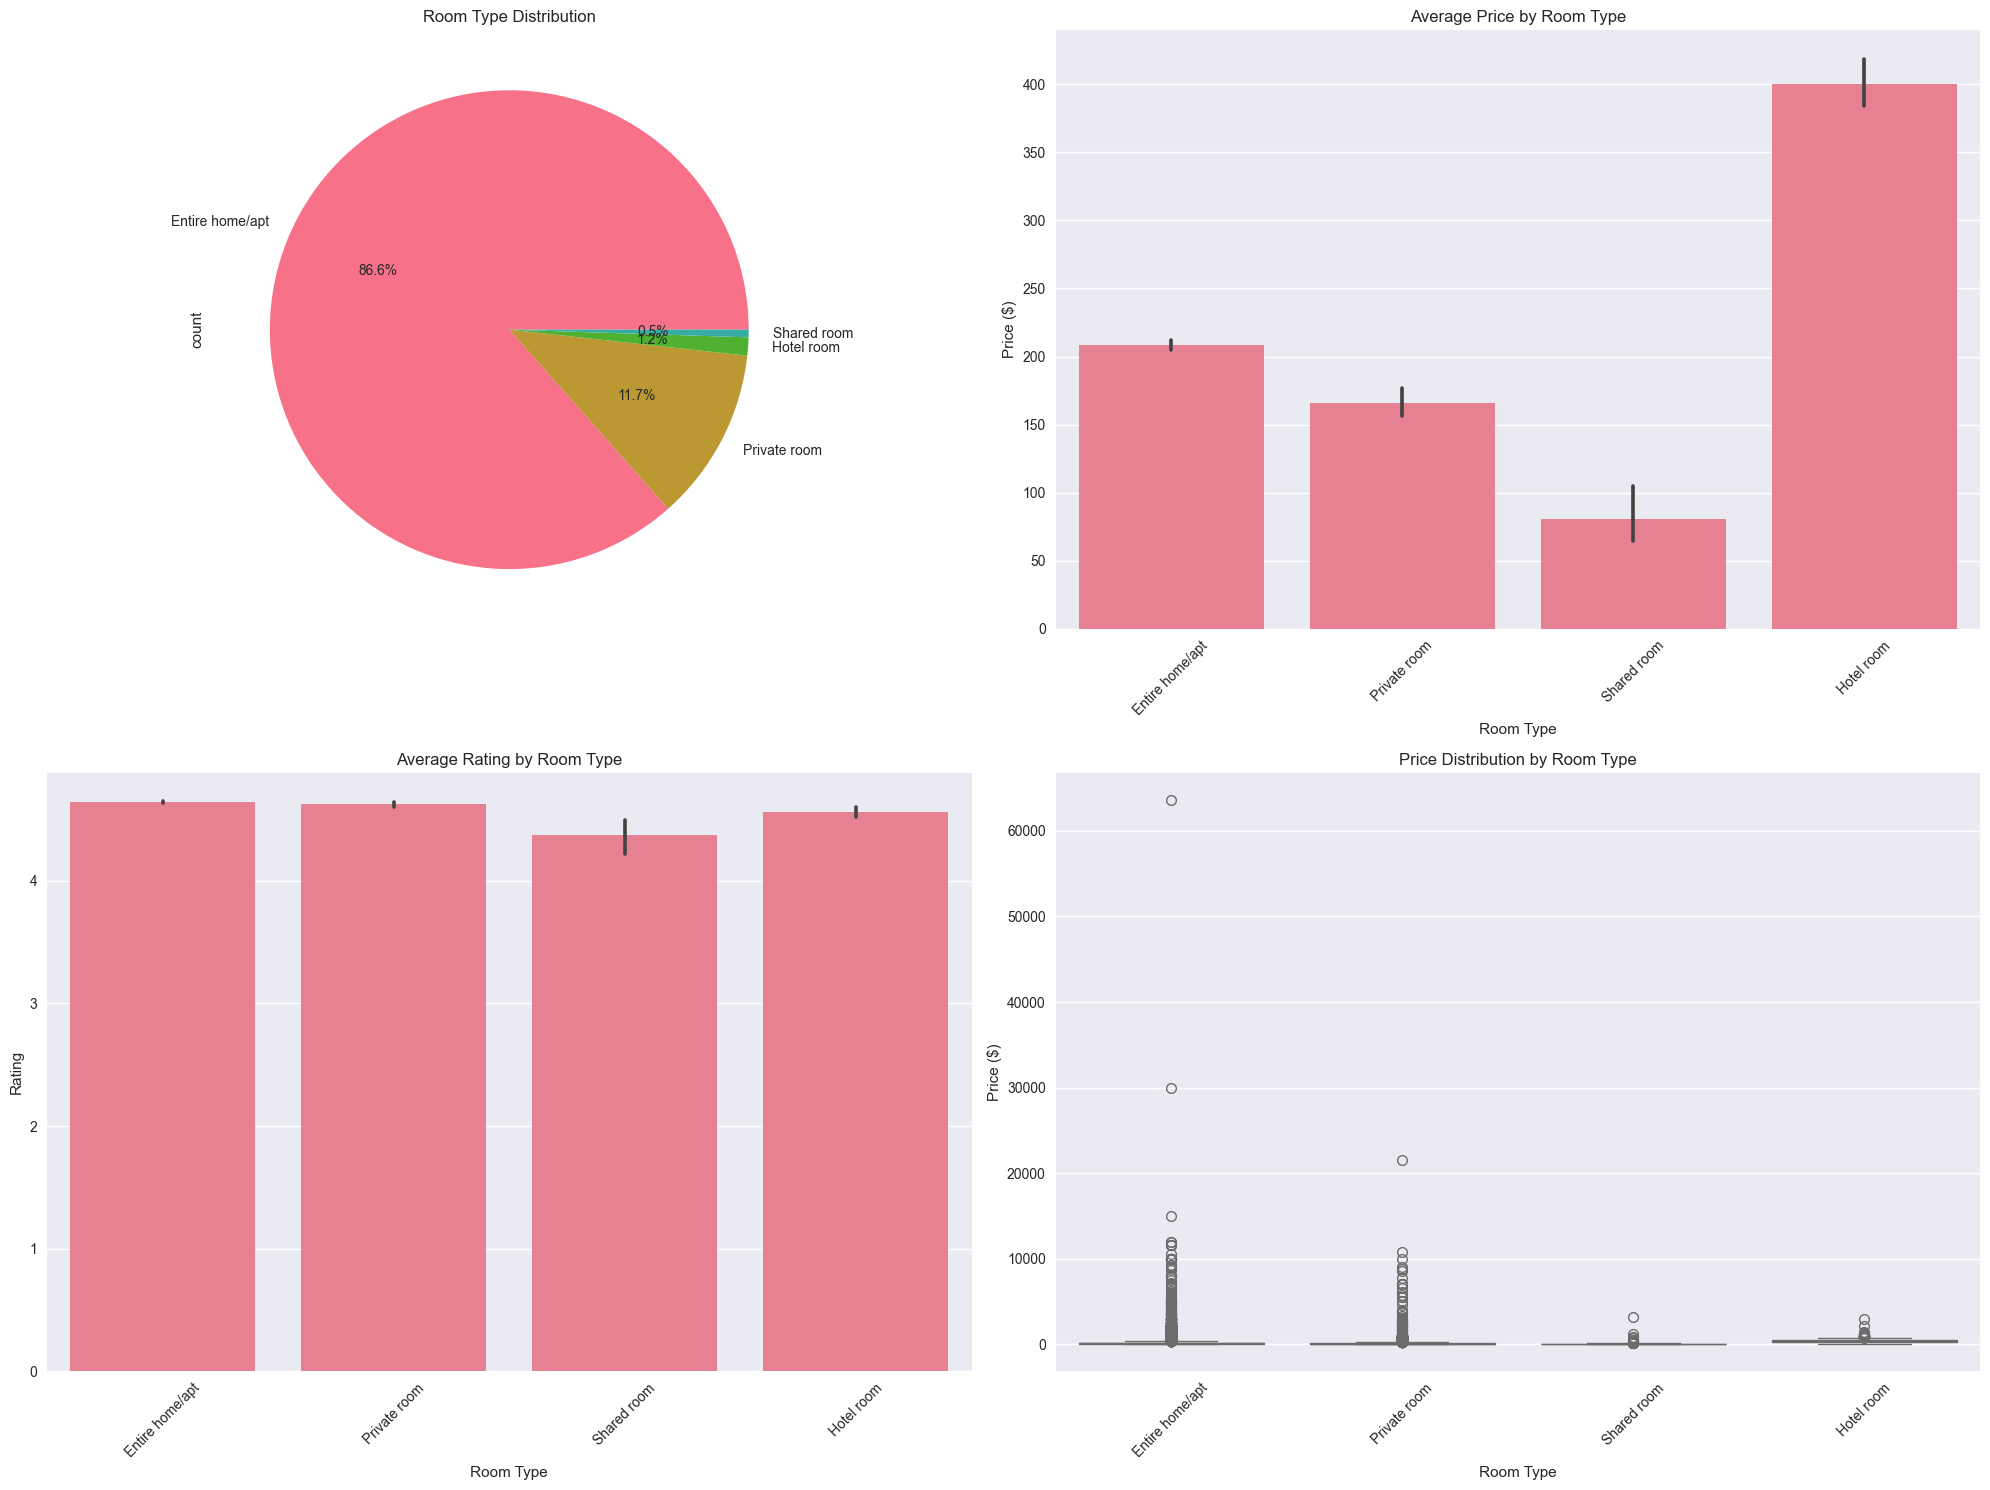

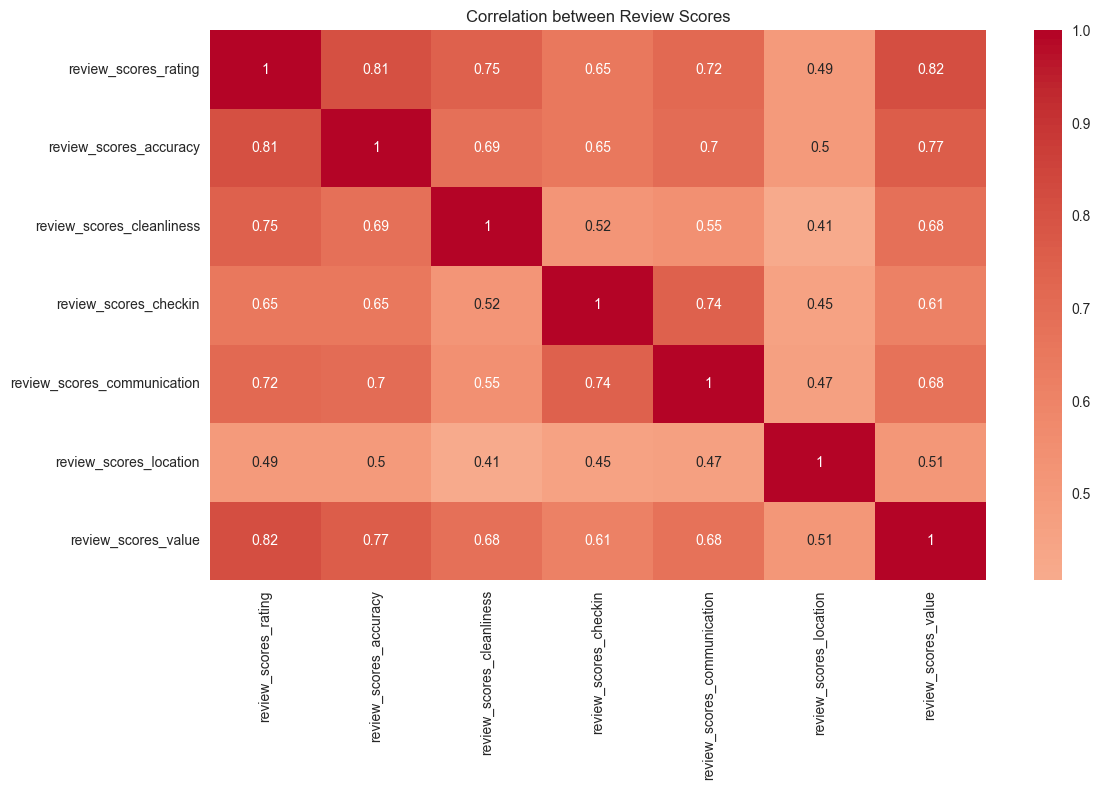

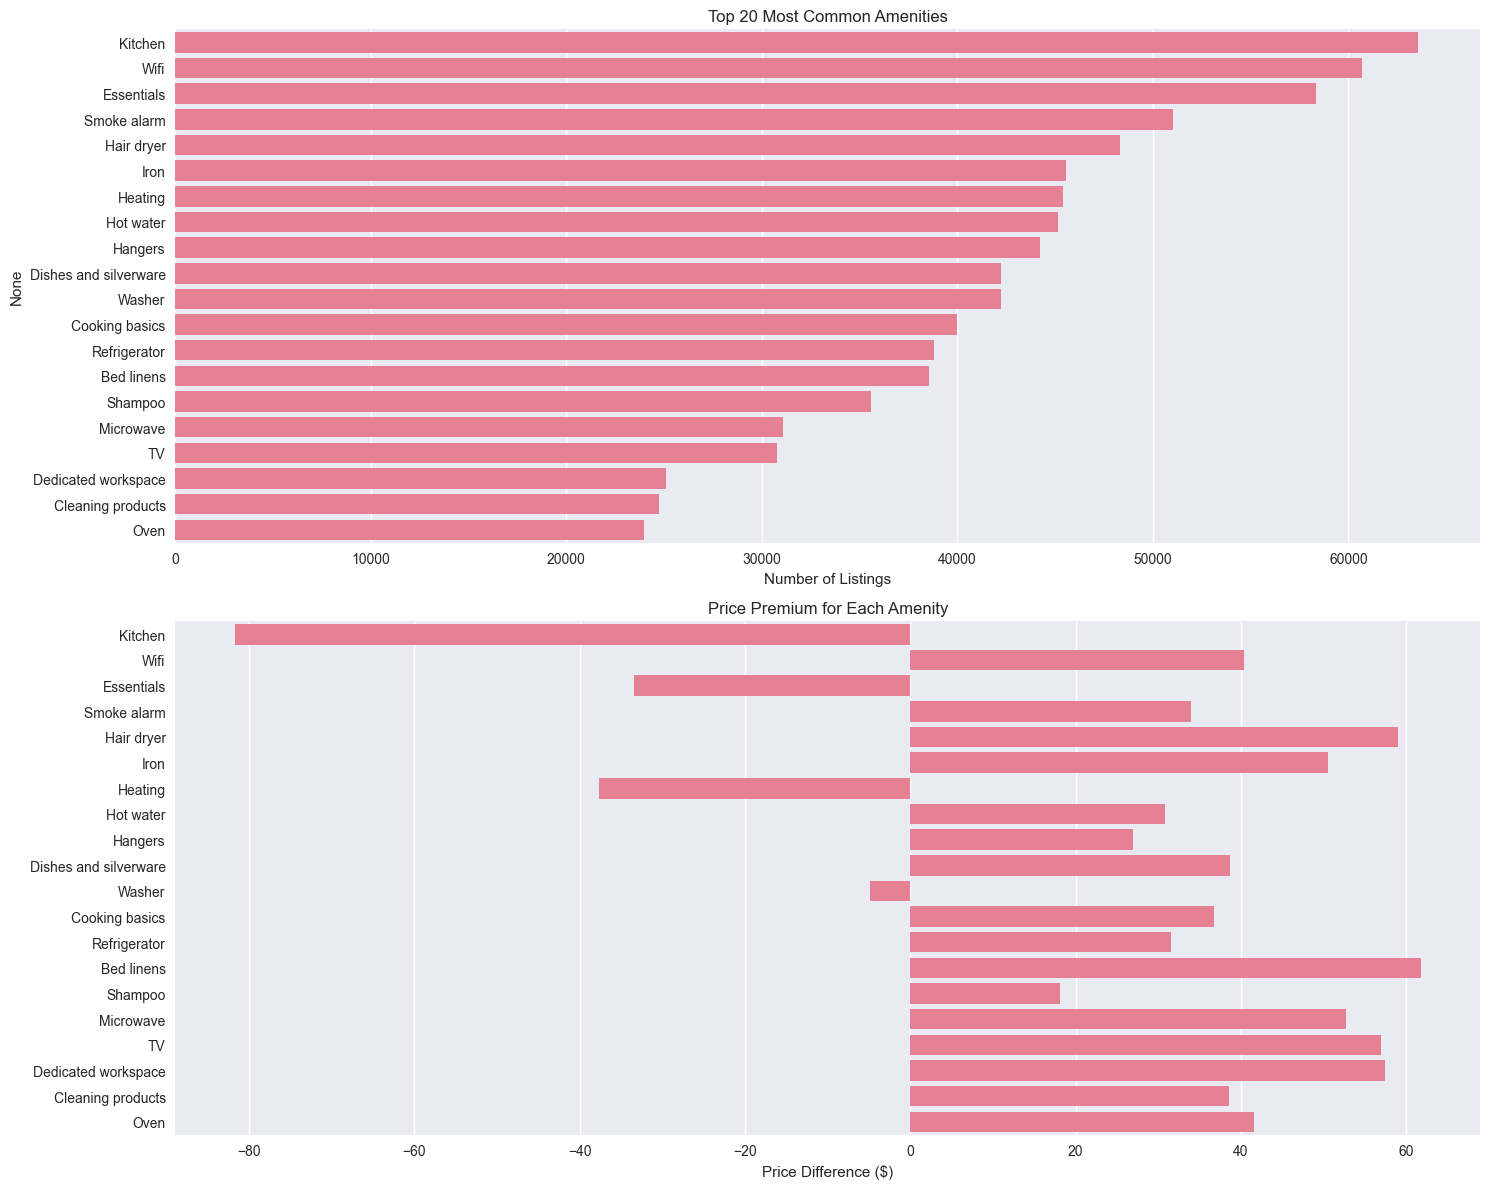

In [10]:
# Example usage - run this in a notebook cell:
city = "paris"
date = "2023-09-04"

# Load data
listings, calendar, neighborhoods = load_city_data(base_folder, city, date)

# Run analyses
print_basic_stats(listings, city, date)
plot_price_distributions(listings, city, date)
plot_neighborhood_analysis(listings)
plot_seasonal_patterns(calendar)
plot_room_type_analysis(listings)
analyze_reviews_ratings(listings)
create_amenities_analysis(listings)

**Preprocessing**

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import pandas as pd

def analyze_amenities(listings):
    """Convert amenities to analyzable format and calculate frequencies"""
    if isinstance(listings['amenities'].iloc[0], str):
        listings['amenities'] = listings['amenities'].apply(eval)
    
    amenity_counts = {}
    total_listings = len(listings)
    
    for amenities_list in listings['amenities']:
        for amenity in amenities_list:
            clean_amenity = amenity.encode('ascii', 'ignore').decode('ascii')
            amenity_counts[clean_amenity] = amenity_counts.get(clean_amenity, 0) + 1
    
    amenity_df = pd.DataFrame.from_dict(amenity_counts, orient='index', columns=['count'])
    amenity_df['frequency'] = amenity_df['count'] / total_listings * 100
    return amenity_df.sort_values('count', ascending=False)

def create_amenity_features(listings, amenity_analysis, min_frequency=5):
    """Create binary features for amenities and amenity categories"""
    frequent_amenities = amenity_analysis[amenity_analysis['frequency'] >= min_frequency].index
    df_features = pd.DataFrame(index=listings.index)
    
    # Binary features for frequent amenities
    for amenity in frequent_amenities:
        col_name = f'amenity_{amenity.lower().replace(" ", "_").replace("-", "_").replace(".", "")}'
        df_features[col_name] = listings['amenities'].apply(
            lambda x: 1 if any(item.strip() == amenity for item in x) else 0
        )
    
    # Category-based features
    amenity_categories = {
        'wifi': ['wifi', 'internet', 'fast wifi', 'wireless'],
        'tv': ['tv', 'hdtv', 'television', 'netflix', 'cable'],
        'kitchen': ['kitchen', 'cooking', 'stove', 'oven', 'refrigerator', 'microwave'],
        'bathroom': ['bath', 'shower', 'bathroom'],
        'workspace': ['workspace', 'desk', 'laptop friendly'],
        'parking': ['parking', 'garage', 'car'],
        'washer': ['washer', 'laundry', 'dryer'],
        'ac': ['air conditioning', 'ac', 'cooling'],
        'outdoor': ['patio', 'balcony', 'garden', 'terrace', 'backyard']
    }
    
    for category, keywords in amenity_categories.items():
        df_features[f'has_{category}'] = listings['amenities'].apply(
            lambda x: 1 if any(any(k.lower() in item.lower() for k in keywords) for item in x) else 0
        )
    
    df_features['amenities_count'] = listings['amenities'].apply(len)
    return df_features

def handle_missing_values(df):
    """Handle missing values in the dataset"""
    df_clean = df.copy()
    
    # Physical attributes
    physical_cols = ['bedrooms', 'beds', 'bathrooms']
    for col in physical_cols:
        medians = df_clean.groupby(['property_type', 'room_type'])[col].transform('median')
        df_clean[col] = df_clean[col].fillna(medians)
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    # Review scores
    review_score_cols = [col for col in df_clean.columns if col.startswith('review_scores_')]
    for col in review_score_cols:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    # Review-related metrics
    df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(0)
    df_clean['has_reviews'] = df_clean['number_of_reviews'].notna() & (df_clean['number_of_reviews'] > 0)
    
    # Remove remaining columns with missing values
    return df_clean.dropna(axis=1)

def scale_and_normalize(df, scaler_type="standard"):
    """Scale and normalize numerical features in the dataset"""
    print("\nScaling and normalizing numerical features...")
    
    # Identify numerical columns (exclude binary and categorical columns)
    numerical_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()
    exclude_cols = [col for col in df.columns if col.startswith('amenity_') or col.startswith('has_')]
    exclude_cols.extend(['id', 'latitude', 'longitude', 'price_clean'])
    numerical_cols = [col for col in numerical_cols if col not in exclude_cols and col != 'price']
    
    print(f"Numerical columns to scale: {numerical_cols}")
    
    # Choose scaler
    scaler = StandardScaler() if scaler_type == "standard" else MinMaxScaler()
    
    # Scale numerical columns
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    
    print(f"Applied {scaler_type} scaling to numerical features.")
    return df

def preprocess_listings(listings, scaler_type="standard"):
    """Main preprocessing pipeline"""
    df = listings.copy()
    
    # Remove unnecessary columns
    columns_to_drop = [
        'listing_url', 'scrape_id', 'last_scraped', 'source', 
        'name', 'description', 'neighborhood_overview', 
        'picture_url', 'neighbourhood', 'neighbourhood_group_cleansed', 
        'calendar_updated', 'license'
    ]
    host_cols = [col for col in df.columns if col.startswith('host_')]
    df = df.drop(columns=[col for col in columns_to_drop + host_cols if col in df.columns])
    
    # Handle missing values
    df = handle_missing_values(df)
    
    # Process amenities
    amenity_analysis = analyze_amenities(df)
    amenity_features = create_amenity_features(df, amenity_analysis, min_frequency=5)
    
    # Combine features
    df = df.drop(columns=['amenities'])
    df = pd.concat([df, amenity_features], axis=1)
    
    # Scale and normalize features
    df = scale_and_normalize(df, scaler_type=scaler_type)
    
    return df, amenity_analysis

def save_processed_df(df, city, date, output_folder):
    """Save processed DataFrame to CSV"""
    filename = f"{city}_{date}_processed.csv"
    filepath = os.path.join(output_folder, filename)
    df.to_csv(filepath, index=False, encoding='utf-8')

if __name__ == "__main__":
    base_folder = 'C:\\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Data_Mor'
    output_folder = 'C:\\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Output'
    city = "paris"
    date = "2023-06-06"
    
    listings, calendar, neighborhoods = load_city_data(base_folder, city, date)
    processed_df, amenity_analysis = preprocess_listings(listings)
    save_processed_df(processed_df, city, date, output_folder)


<>:136: SyntaxWarning: invalid escape sequence '\m'
<>:137: SyntaxWarning: invalid escape sequence '\m'
<>:136: SyntaxWarning: invalid escape sequence '\m'
<>:137: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matth\AppData\Local\Temp\ipykernel_21336\4177160371.py:136: SyntaxWarning: invalid escape sequence '\m'
  base_folder = 'C:\\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Data_Mor'
C:\Users\matth\AppData\Local\Temp\ipykernel_21336\4177160371.py:137: SyntaxWarning: invalid escape sequence '\m'
  output_folder = 'C:\\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Output'
c:\Users\matth\anaconda3\envs\Spatiotemporal_Analytics\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Scaling and normalizing numerical features...
Numerical columns to scale: ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'amenities_count']
Applied standard scaling to numerical features.


In [17]:
def combine_listings_calendar(listings_df, calendar_df):
    """Combine listings and calendar data with temporal features"""
    # Create a copy to avoid modifying original data
    calendar_df = calendar_df.copy()
    
    # Clean price columns
    def clean_price(price):
        if pd.isna(price):
            return np.nan
        if isinstance(price, str):
            return float(price.replace('$', '').replace(',', '').strip())
        return price
    
    # Clean the price column
    calendar_df['price'] = calendar_df['price'].apply(clean_price)
    calendar_df['adjusted_price'] = calendar_df['adjusted_price'].apply(clean_price)
    
    # Convert date to datetime
    calendar_df['date'] = pd.to_datetime(calendar_df['date'])
    
    # Create temporal features from date
    calendar_df['year'] = calendar_df['date'].dt.year
    calendar_df['month'] = calendar_df['date'].dt.month
    calendar_df['day_of_week'] = calendar_df['date'].dt.dayofweek
    calendar_df['is_weekend'] = calendar_df['day_of_week'].isin([5, 6]).astype(int)
    calendar_df['season'] = calendar_df['month'].map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall'
    })
    
    # Convert available to binary
    calendar_df['available'] = calendar_df['available'].map({'t': 1, 'f': 0})
    
    # Calculate listing-level temporal statistics
    temporal_stats = calendar_df.groupby('listing_id').agg({
        'price': ['mean', 'std', 'min', 'max'],
        'adjusted_price': ['mean', 'std', 'min', 'max'],
        'available': 'mean',
        'minimum_nights': 'mean',
        'maximum_nights': 'mean',
        'is_weekend': 'mean'
    }).round(2)
    
    # Flatten column names
    temporal_stats.columns = [f'calendar_{col[0]}_{col[1]}' for col in temporal_stats.columns]
    
    # Handle NaN values in temporal stats
    temporal_stats = temporal_stats.fillna(temporal_stats.mean())
    
    # Merge with listings data
    combined_df = listings_df.merge(temporal_stats, left_on='id', right_index=True, how='left')
    
    # Fill any remaining NaN values from the merge
    for col in temporal_stats.columns:
        if col in combined_df.columns:
            combined_df[col] = combined_df[col].fillna(combined_df[col].mean())
    
    return combined_df

def add_spatial_features(df):
    """Add spatial features and interactions"""
    # Create location-based features
    df['lat_bin'] = pd.qcut(df['latitude'], q=10, labels=False)
    df['lon_bin'] = pd.qcut(df['longitude'], q=10, labels=False)
    
    # Calculate distance to city center
    city_centers = {
        'amsterdam': (52.3676, 4.9041),
        'barcelona': (41.3851, 2.1734),
        'berlin': (52.5200, 13.4050),
        'london': (51.5074, -0.1278),
        'paris': (48.8566, 2.3522),
        'rome': (41.9028, 12.4964)
    }
    
    def calculate_distance(row, city_center):
        return np.sqrt(
            (row['latitude'] - city_center[0])**2 + 
            (row['longitude'] - city_center[1])**2
        ) * 111  # Convert to approximate kilometers
    
    # If city information is available, use city-specific centers
    if 'city' in df.columns:
        df['distance_to_center'] = np.nan
        for city, coords in city_centers.items():
            city_mask = df['city'] == city
            if city_mask.any():
                df.loc[city_mask, 'distance_to_center'] = df[city_mask].apply(
                    lambda x: calculate_distance(x, coords), axis=1
                )
    else:
        # Use the mean coordinates as center
        mean_lat = df['latitude'].mean()
        mean_lon = df['longitude'].mean()
        df['distance_to_center'] = df.apply(
            lambda x: calculate_distance(x, (mean_lat, mean_lon)), axis=1
        )
    
    return df

# Modified main execution block
if __name__ == "__main__":
    base_folder = 'C:\\Users\\matth\\OneDrive\\Documents\\KU Leuven\\Thesis\\Data_Mor'
    output_folder = 'C:\\Users\\matth\\OneDrive\\Documents\\KU Leuven\\Thesis\\Output'
    city = "paris"
    date = "2023-06-06"
    
    # Load data
    listings, calendar, neighborhoods = load_city_data(base_folder, city, date)
    
    # Combine listings and calendar data
    combined_df = combine_listings_calendar(listings, calendar)
    
    # Add spatial features
    combined_df = add_spatial_features(combined_df)
    
    # Apply your existing preprocessing
    processed_df, amenity_analysis = preprocess_listings(combined_df)
    
    # Save the enhanced processed data
    save_processed_df(processed_df, city, date, output_folder)

c:\Users\matth\anaconda3\envs\Spatiotemporal_Analytics\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Scaling and normalizing numerical features...
Numerical columns to scale: ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'calendar_price_mean', 'calendar_price_std', 'calendar_price_min', 'calendar_price_max', 'calendar_adjusted_price_mean', 'calendar_adjusted_price_std', 'calendar_adjusted_price_min', 'calendar_adjusted_price_max', 'calendar_available_mean', 'calendar_minimum_nights_mean', 'calendar_maximum_nights_mean', 'calendar_is_week

**MODEL**

In [27]:
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Add this import

def prepare_model_data(processed_df):
    """
    Prepare data for modeling, separating features and target
    """
    # Remove any non-feature columns
    cols_to_drop = [
        'id', 'listing_id', 'price', 'first_review', 'last_review',
        'calendar_last_scraped', 'has_availability', 'scrape_date'
    ]
    
    feature_df = processed_df.copy()
    for col in cols_to_drop:
        if col in feature_df.columns:
            feature_df = feature_df.drop(columns=[col])
    
    # Get only numeric columns
    numeric_columns = feature_df.select_dtypes(include=['int64', 'float64']).columns
    
    # Print non-numeric columns for debugging
    non_numeric = [col for col in feature_df.columns if col not in numeric_columns]
    print("Dropping non-numeric columns:", non_numeric)
    
    # Keep only numeric columns
    feature_df = feature_df[numeric_columns]
    
    # Separate target variable
    if 'price_clean' in feature_df.columns:
        y = feature_df['price_clean']
        X = feature_df.drop(columns=['price_clean'])
    else:
        raise ValueError("No target variable 'price_clean' found in the dataset")
    
    # Handle any remaining NaN values
    X = X.fillna(X.mean())
    y = y.fillna(y.mean())
    
    print("\nFinal feature matrix shape:", X.shape)
    print("Features used:", X.columns.tolist())
    
    return X, y

def train_models(X, y, random_state=42):
    """
    Train multiple regression models and evaluate their performance
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models with different regularization approaches
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5)
    }
    
    results = {}
    feature_importance_dict = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
        
        # Calculate metrics
        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        
        # Perform time series cross-validation
        tscv = TimeSeriesSplit(n_splits=5)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                  cv=tscv, scoring='r2')
        
        # Store results
        results[name] = {
            'model': model,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'test_mae': test_mae,
            'cv_scores': cv_scores,
            'y_pred_test': y_pred_test,
            'y_test': y_test
        }
        
        # Calculate feature importance
        if hasattr(model, 'coef_'):
            feature_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': np.abs(model.coef_)
            }).sort_values('importance', ascending=False)
            feature_importance_dict[name] = feature_importance
        
        # Print results
        print(f"\n{name} Results:")
        print(f"Training RMSE: ${train_rmse:.2f}")
        print(f"Testing RMSE: ${test_rmse:.2f}")
        print(f"Training R²: {train_r2:.4f}")
        print(f"Testing R²: {test_r2:.4f}")
        print(f"Testing MAE: ${test_mae:.2f}")
        print(f"Cross-validation R² scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        if name in feature_importance_dict:
            print("\nTop 10 Most Important Features:")
            print(feature_importance_dict[name].head(10))
    
    return results, feature_importance_dict, scaler

def plot_results(results):
    """
    Create visualizations for model results
    """
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Model Comparison Plot
    plt.subplot(2, 2, 1)
    model_names = list(results.keys())
    test_r2_scores = [results[name]['test_r2'] for name in model_names]
    
    bars = plt.bar(model_names, test_r2_scores)
    plt.title('Model Comparison (Test R² Scores)', fontsize=12)
    plt.xticks(rotation=45)
    plt.ylabel('R² Score')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')
    
    # 2. Actual vs Predicted Plot (for best model)
    plt.subplot(2, 2, 2)
    best_model_name = max(results.items(), key=lambda x: x[1]['test_r2'])[0]
    best_results = results[best_model_name]
    
    plt.scatter(best_results['y_test'], best_results['y_pred_test'], alpha=0.5)
    plt.plot([best_results['y_test'].min(), best_results['y_test'].max()],
             [best_results['y_test'].min(), best_results['y_test'].max()],
             'r--', lw=2)
    plt.title(f'Actual vs Predicted Prices ({best_model_name})', fontsize=12)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    
    # 3. Residuals Plot
    plt.subplot(2, 2, 3)
    residuals = best_results['y_test'] - best_results['y_pred_test']
    plt.scatter(best_results['y_pred_test'], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals Plot', fontsize=12)
    plt.xlabel('Predicted Price')
    plt.ylabel('Residuals')
    
    # 4. Error Distribution
    plt.subplot(2, 2, 4)
    sns.histplot(residuals, kde=True)
    plt.title('Error Distribution', fontsize=12)
    plt.xlabel('Residual Error')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()


c:\Users\matth\anaconda3\envs\Spatiotemporal_Analytics\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Scaling and normalizing numerical features...
Numerical columns to scale: ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'calendar_price_mean', 'calendar_price_std', 'calendar_price_min', 'calendar_price_max', 'calendar_adjusted_price_mean', 'calendar_adjusted_price_std', 'calendar_adjusted_price_min', 'calendar_adjusted_price_max', 'calendar_available_mean', 'calendar_minimum_nights_mean', 'calendar_maximum_nights_mean', 'calendar_is_week

c:\Users\matth\anaconda3\envs\Spatiotemporal_Analytics\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.865e+06, tolerance: 1.463e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\matth\anaconda3\envs\Spatiotemporal_Analytics\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.982e+08, tolerance: 4.844e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\matth\anaconda3\envs\Spatiotemporal_Analytics\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca


Lasso Regression Results:
Training RMSE: $299.00
Testing RMSE: $297.42
Training R²: 0.6984
Testing R²: 0.6556
Testing MAE: $40.50
Cross-validation R² scores: 0.1390 (+/- 1.7570)

Top 10 Most Important Features:
                                         feature  importance
32                   calendar_adjusted_price_min  327.753860
33                   calendar_adjusted_price_max  305.906581
29                            calendar_price_max  220.669532
27                            calendar_price_std   79.701266
26                           calendar_price_mean   48.723753
24   calculated_host_listings_count_shared_rooms   11.415920
41                               amenity_kitchen    7.996321
120                                  has_kitchen    5.973266
72                               amenity_toaster    5.882622
13                        number_of_reviews_l30d    5.449247

Training ElasticNet...

ElasticNet Results:
Training RMSE: $308.08
Testing RMSE: $288.89
Training R²: 0.6798
Testing

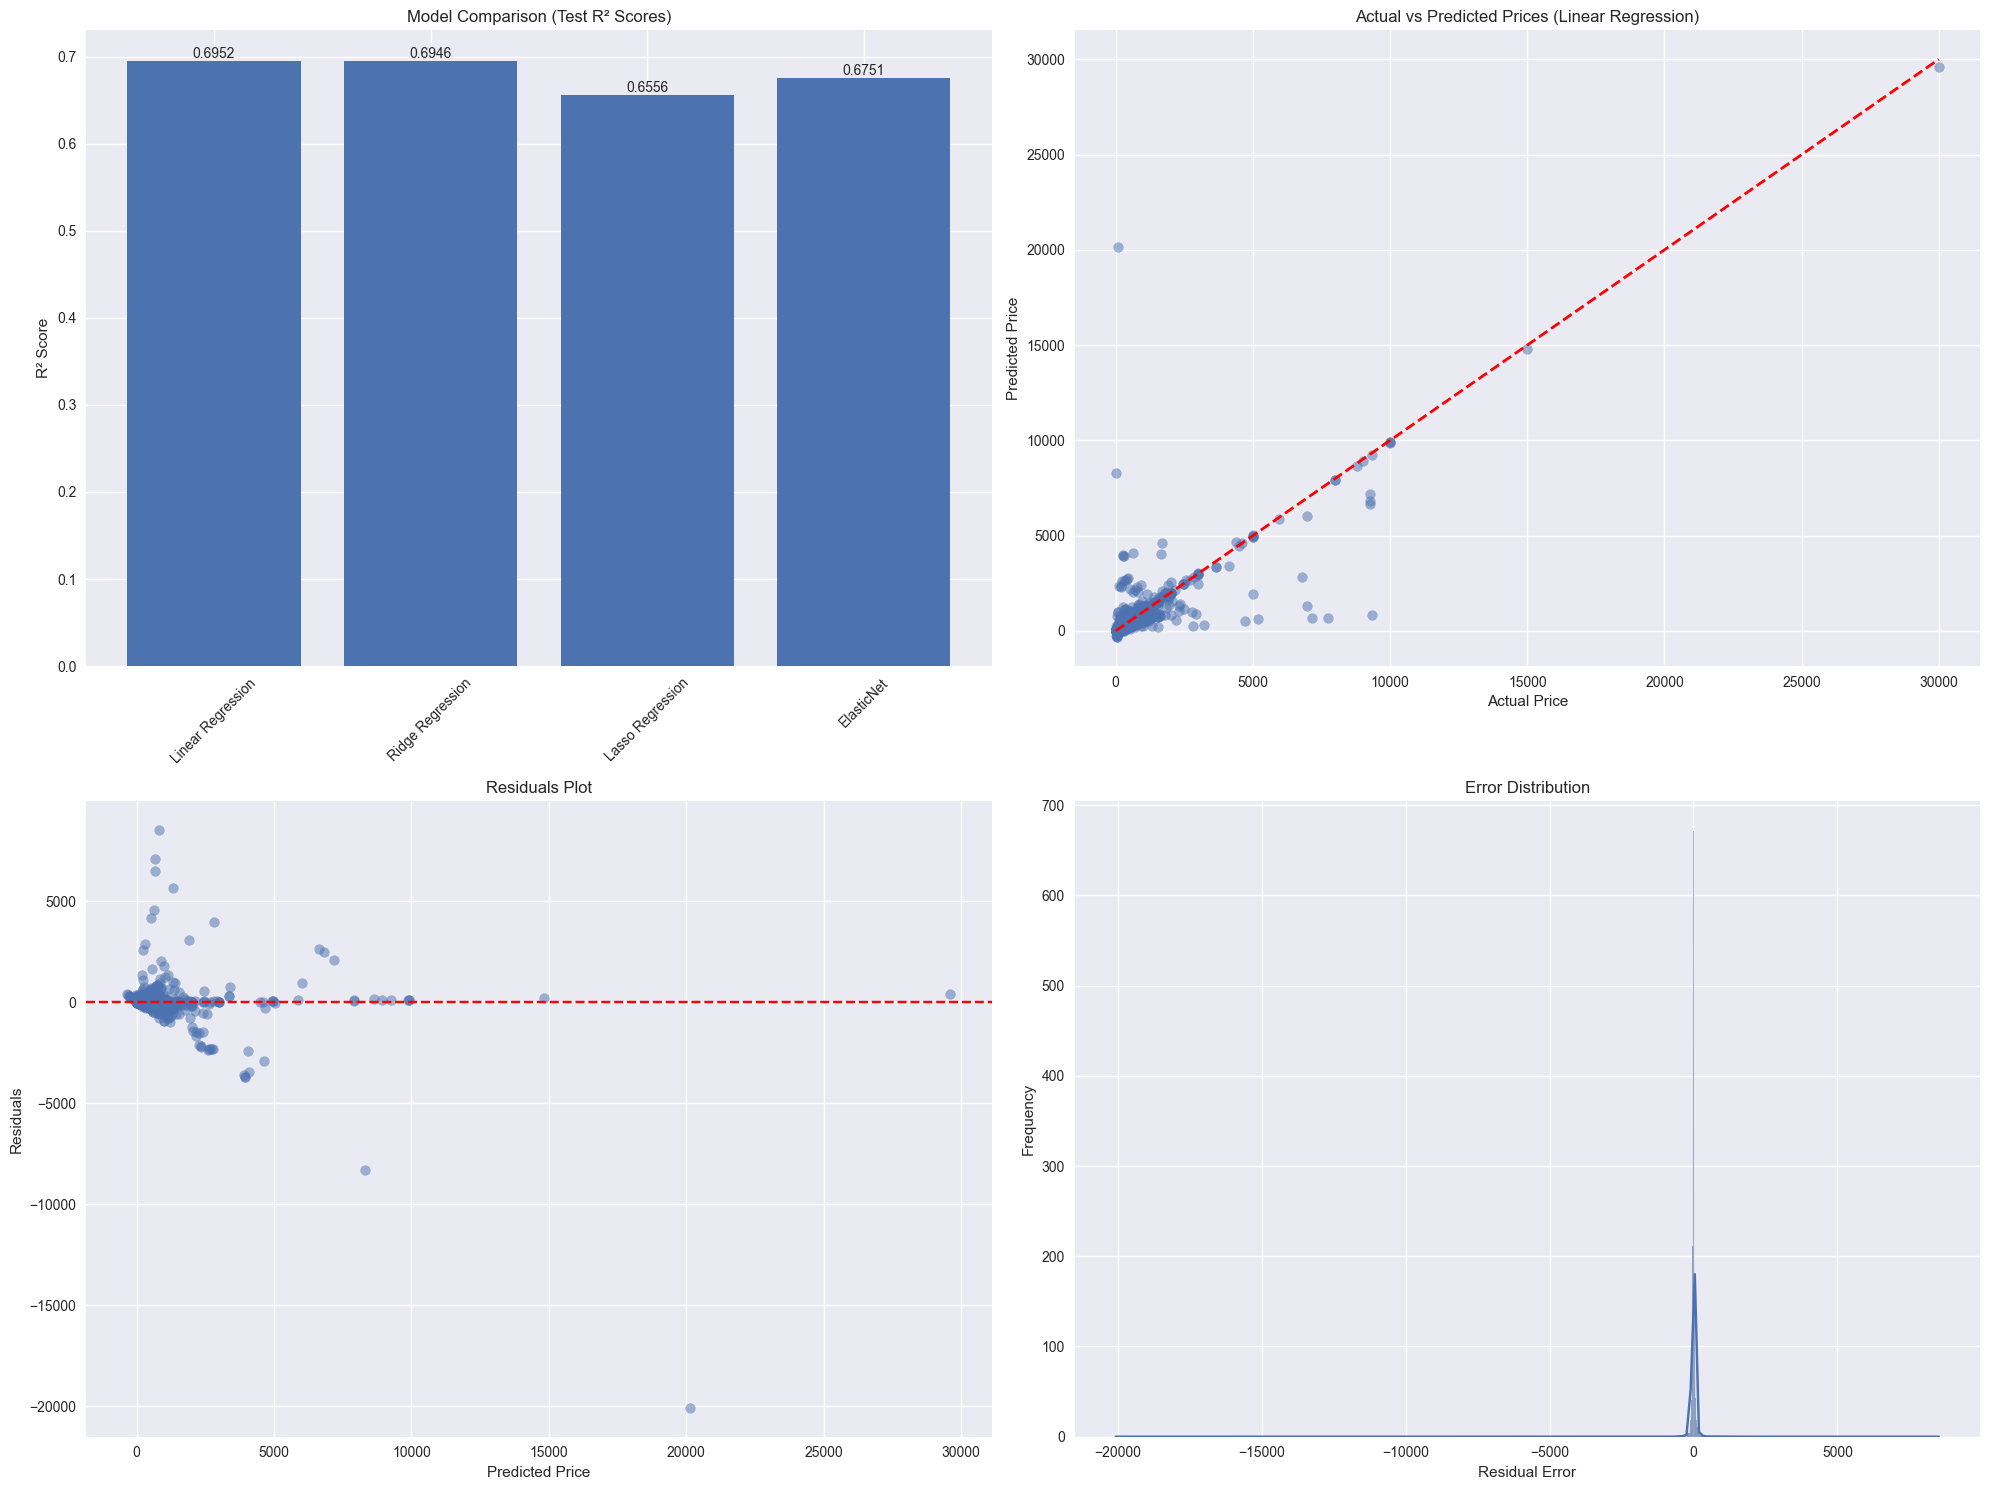


Top 20 most important features for best model:
                                          feature   importance
26                            calendar_price_mean  1068.897876
30                   calendar_adjusted_price_mean  1057.648509
33                    calendar_adjusted_price_max   976.652796
29                             calendar_price_max   874.799498
32                    calendar_adjusted_price_min   753.577434
28                             calendar_price_min   399.008464
27                             calendar_price_std   275.886374
31                    calendar_adjusted_price_std   214.284738
21                 calculated_host_listings_count   203.109755
22    calculated_host_listings_count_entire_homes   197.564612
23   calculated_host_listings_count_private_rooms    29.516468
35                   calendar_minimum_nights_mean    24.419888
127                               amenities_count    23.727872
5                                  minimum_nights    21.160631
41     

In [25]:
if __name__ == "__main__":
    # 1. Load initial data
    base_folder = 'C:\\Users\\matth\\OneDrive\\Documents\\KU Leuven\\Thesis\\Data_Mor'
    city = "paris"
    date = "2023-06-06"
    
    listings, calendar, neighborhoods = load_city_data(base_folder, city, date)
    
    # 2. Combine listings with calendar to add temporal features
    combined_df = combine_listings_calendar(listings, calendar)
    
    # 3. Add spatial features
    combined_df = add_spatial_features(combined_df)
    
    # 4. Apply your preprocessing
    processed_df, amenity_analysis = preprocess_listings(combined_df)
    
    # 5. Prepare final data for modeling
    X, y = prepare_model_data(processed_df)
    
    # 6. Train the spatiotemporal models
    results, feature_importance_dict, scaler = train_models(X, y)
    
    # 7. Visualize results
    plot_results(results)
    
    # 8. Print feature importance to see which spatial/temporal features matter most
    best_model_name = max(results.items(), key=lambda x: x[1]['test_r2'])[0]
    print("\nTop 20 most important features for best model:")
    print(feature_importance_dict[best_model_name].head(20))